In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import warnings
import os
import sys
import matplotlib.pyplot as plt

In [31]:
# HARDCODED
os.chdir('/home/stefan/jupyter-lab-projects/CLL/bee-project/honey_bee_behavior') #working directory
sys.path.append("/home/stefan/jupyter-lab-projects/CLL/bee-project/honey_bee_behavior") #module directory

from bees_lifetimetracking_2018data import datafunctions

In [32]:
#DELETED FREQ PARAMETER FROM DEFINITIONS_2018
from bees_lifetimetracking_2018data import definitions_2018 as bd

In [33]:
import pandas as pd
import numpy as np
from matplotlib import colors
import seaborn as sns


year = 2018
startday = pd.Timestamp(year,7,16)  # actual, for 2018:   16 July  (cameras turned on)
endday = pd.Timestamp(year,10,9)    # actual, for 2018:   was 10 September, but is now 09 Oct
alldaytimestamps = pd.date_range(start=startday,end=endday,freq='D')
numdays = len(alldaytimestamps)  # just do to 43?
numbees = 4096  #  I think 4096 is the total number.  This is the total number of barcodes, NOT the total number of bees actually tracked
numsubstrates = 10 # 10 actual substrates, and then 0 for undefined
comb_daynums = np.array([ 0,  5, 10, 15, 20, 26, 30, 35, 40, 44, 65, 75, 85]) + 16 - startday.day  # days from start day, assuming start day is in July

# HARDCODED
path_to_cohorts = '/home/stefan/jupyter-lab-projects/CLL/bee-project/honey_bee_behavior/bees_lifetimetracking_2018data/all_cohorts.csv'

# get bee cohort data, and just process these for a single one
cohort_data = pd.read_csv(path_to_cohorts)
cohort_colornames = np.unique(cohort_data['cohort'])
cohort_tagids = [np.array(cohort_data[cohort_data['cohort']==name]['beeID']) for name in cohort_colornames]
cohort_birthdates = np.array([pd.Timestamp(np.array(cohort_data['DOB'][cohort_data['cohort']==c])[0]) for c in cohort_colornames])

In [34]:
from bees_lifetimetracking_2018data import displayfunctions as bp
datafunctions.init(bd) 
bp.init(bd)

warnings.filterwarnings("ignore")

In [35]:
PATH = '/home/stefan/jupyter-lab-projects/CLL/bee-data/'

In [34]:
def getExitFrameLocation(df):
    #hardcoded!!
    x_max = 6500
    x_min = 3500
    y_min = 3800
    y_max = 5400
    
    x = np.array(df['x']).astype(float)
    y = np.array(df['y']).astype(float)
    camera = np.array(df['camera']).astype(int)
    conv_factor = 1
    x_adjusted = x/conv_factor + (np.logical_not(camera).astype(int))*bd.xpixels
    y_adjusted = y/conv_factor

    
    x_bounds = (x_adjusted >= x_min) & (x_adjusted <= x_max)
    y_bounds = (y_adjusted >= y_min) & (y_adjusted <= y_max)
    
    df['in_exit_frame'] = (x_bounds & y_bounds).astype('int')
    
    return df

In [35]:
def crossedDanceFloor(df):
    x_max = 6000
    x_min = 4700
    y_min = 4350
    y_max = 5200
#     dance_floor={'top':4350,'bottom':5200,'right':6000,'left':4700}
    x = np.array(df['x']).astype(float)
    y = np.array(df['y']).astype(float)
    camera = np.array(df['camera']).astype(int)
    conv_factor = 1
    x_adjusted = x/conv_factor + (np.logical_not(camera).astype(int))*bd.xpixels
    y_adjusted = y/conv_factor

    
    x_bounds = (x_adjusted >= x_min) & (x_adjusted <= x_max)
    y_bounds = (y_adjusted >= y_min) & (y_adjusted <= y_max)
    
    df['cross_df'] = (x_bounds & y_bounds).astype('int')
    
    return df

In [36]:
def numOfDanceFloorVisits(df):
    dance = df.groupby(['uid','daynum'])['cross_df'].sum().to_frame(name='df_visits').reset_index()
    df = pd.merge(df,dance, on=['uid','daynum'], how='left')
    
    return df
    

In [37]:
def getExitDist(df):
    df['exit_dist'] = datafunctions.getexitdistance(df.x,df.y,df.camera)
    return df
# add on to dataframe for plotting purposes!

In [38]:
def get5MinBounds(time):
    lower = int(time - 900) 
    upper = int(time + 900)
    return upper,lower

In [39]:
def getBeeTraj(daynum,df):
    if daynum >= 50:
        datadir = PATH + 'beetrajectories_days_050_to_085/'
    else:
        datadir = PATH + 'beetrajectories_days_000_to_049/'

    beeTrajectoriesByFrame = pd.read_hdf('{}beetrajectories_{:0>3}.hdf'.format(datadir,daynum)) #data per frame in which each bee was seen
    return beeTrajectoriesByFrame

In [40]:
def loadData(daynum, df):
    if daynum >= 50:
        datadir = PATH + 'beetrajectories_days_050_to_085/'
    else:
        datadir = PATH + 'beetrajectories_days_000_to_049/'

    beeTrajectoriesByFrame = pd.read_hdf('{}beetrajectories_{:0>3}.hdf'.format(datadir,daynum)) #data per frame in which each bee was seen
    
    ### DID THE BEE LEAVE? ------------------------------------------------------------------
    dataDir = PATH + 'df_day1min_alldays/'
    dfday = pd.read_hdf('{}df_day1min_{:0>2}.hdf'.format(dataDir,daynum))
    numtimedivs = len(dfday['timedivision'].unique()) # minutes in a day
    day_uids, day_ages, boolInHiveByIDByTime, bee_obs, bee_exitdist = datafunctions.get_inout_estimates(dfday, numtimedivs=numtimedivs)
    

In [41]:
def getHiveEvents(daynum,df):
    if daynum >= 50:
        datadir = PATH + 'beetrajectories_days_050_to_085/'
    else:
        datadir = PATH + 'beetrajectories_days_000_to_049/'

    beeTrajectoriesByFrame = pd.read_hdf('{}beetrajectories_{:0>3}.hdf'.format(datadir,daynum)) #data per frame in which each bee was seen
    
    ### DID THE BEE LEAVE? ------------------------------------------------------------------
    dataDir = PATH + 'df_day1min_alldays/'
    dfday = pd.read_hdf('{}df_day1min_{:0>2}.hdf'.format(dataDir,daynum))
    numtimedivs = len(dfday['timedivision'].unique()) # minutes in a day
    day_uids, day_ages, boolInHiveByIDByTime, bee_obs, bee_exitdist = datafunctions.get_inout_estimates(dfday, numtimedivs=numtimedivs)
    
    #TOTAL 2066400, 1 MINUTE CHUNKS
    
    # boolInHiveByIDByTime into dataframe ----------------------------------------------------
    inHive = pd.DataFrame(boolInHiveByIDByTime)
    inHive = inHive.T #transpose so rows = time and cols = uid
                                
    #get hive statuses by taking difference on axis 0 (rows, which represent time)
    hive_statuses_list = np.diff(inHive, axis = 0) # TODO document code
    #print(len(hive_statuses_list[1])) #PRINT CHECK (len 1439, len of each is 1435)
    
    # translate time to framenum (assuming 3 frames per second)-------------------------------
    frames_per_day = 24*60*60*3
    frames_per_timedivision = frames_per_day / numtimedivs
    
    """
    inHive['index'] = range(len(inHive))
    inHive['minsPastMidnight'] = inHive['index']*1 #bin size = 1min (see datafunctions.py), TODO un-hardcode
    
    
    inHive['framenum'] = inHive['index']*frames_per_timedivision
    """
    
    hive_statuses_by_uid = []
    
    #return [i for i in zip(day_uids,hive_statuses_list)]
    
    hive_statuses_list = np.transpose(hive_statuses_list) # First index is beeUID, second is minute
    for uid, hive_statuses in zip(day_uids,hive_statuses_list):
        for hive_status in hive_statuses:
            hive_statuses_by_uid.append([uid,hive_status])
    df_hive_events = pd.DataFrame(hive_statuses_by_uid,columns=['uid','diff'])
    df_hive_events['index'] = range(len(df_hive_events))
    
    #minutes and framenum columns---------------------------------------------------------------
    result = []
    numEntriesPerUid = len(df_hive_events[df_hive_events['uid'] == df_hive_events['uid'].iat[0]])
    for value in df_hive_events['index']:
        result.append(value % numEntriesPerUid)
    df_hive_events['min'] = result
    
    df_hive_events['framenum'] = df_hive_events['min']*frames_per_day/(24*60)
    
    df_hive_events = df_hive_events[['index', 'uid', 'diff', 'min', 'framenum']]
    
    #stauses--------------------------------------------------------------------------------------
    conditions = [
        (df_hive_events['diff'] == -1.0),
        (df_hive_events['diff'] == 1.0),
        (df_hive_events['diff'] == 0.0),
    ]
    choices = ['leave', 'return', 'no change']
    df_hive_events['status'] = np.select(conditions, choices, default='not sure')
    
    
    """
    for plotting purposes, single out rows in beetraj df and surrounding rows to track data.
    
    add function to do exit distance and num dance floor visits for selected rows (new df)
    """
    
    return df_hive_events

In [42]:
def getLeaveEvents(daynum,df):
    beeTraj = pd.DataFrame()
    beeTraj = getBeeTraj(daynum, beeTraj)
    hiveEvents = pd.DataFrame()
    hiveEvents = getHiveEvents(daynum, hiveEvents)
    
    dfIntersect = pd.merge(hiveEvents, beeTraj, how='inner', on = ['uid','framenum'])
    
    return dfIntersect[dfIntersect['status']=='leave']

In [43]:
def getPlottingEvent(daynum, df, frame, beeID, framesBefore, framesAfter):
    beeTraj = pd.DataFrame()
    beeTraj = getBeeTraj(daynum, beeTraj)
    
    #filter data to just the one bee
    filteredBee = beeTraj[beeTraj['uid']==beeID]
    
    # set desired range of frames
    minFrame = frame - framesBefore #recommended frames before: 1800 (10 minutes), frames after: 50 (just to see the bee is back)
    maxFrame = frame + framesAfter
    plottingEvents = pd.DataFrame()
    
    #filtering for desired frames of the bee's data
    filtered_rows = filteredBee[(filteredBee['framenum'] >= minFrame) & (filteredBee['framenum'] <= maxFrame)]

    #adding filtered rows to resulting dataframe
    plottingEvents = pd.concat([plottingEvents, filtered_rows], ignore_index=True)

    return plottingEvents

In [47]:
def plotEvent(daynum, df, frame, beeID, framesBefore, framesAfter):
    # getting desired rows
    plotPoint = pd.DataFrame()
    plotPoint = getPlottingEvent(daynum, df, frame, beeID, framesBefore, framesAfter)

    # create figure x = framenum, y = y, color gradient = x
    plt.figure(figsize=(10, 6))
    plt.scatter(plotPoint['framenum'], plotPoint['y'], c=plotPoint['x'], cmap='viridis', s=10, alpha=0.8, label='Data')  

    # labeling color bar
    cbar = plt.colorbar()
    cbar.set_label('X Coordinate')

    #labels
    plt.xlabel('Frame Number')
    plt.ylabel('Y Coordinate')
    plt.title('Plot of Y Coordinate vs. Frame Number with X Coordinate Variation')

    # red dashed line to indicate where the 'leave' event is
    plt.axvline(x=frame, color='red', linestyle='--', label='Chosen frame of event')

    #Add grid and legend, then show plot
    plt.grid(True)
    plt.legend(loc = 'lower right')
    plt.show()

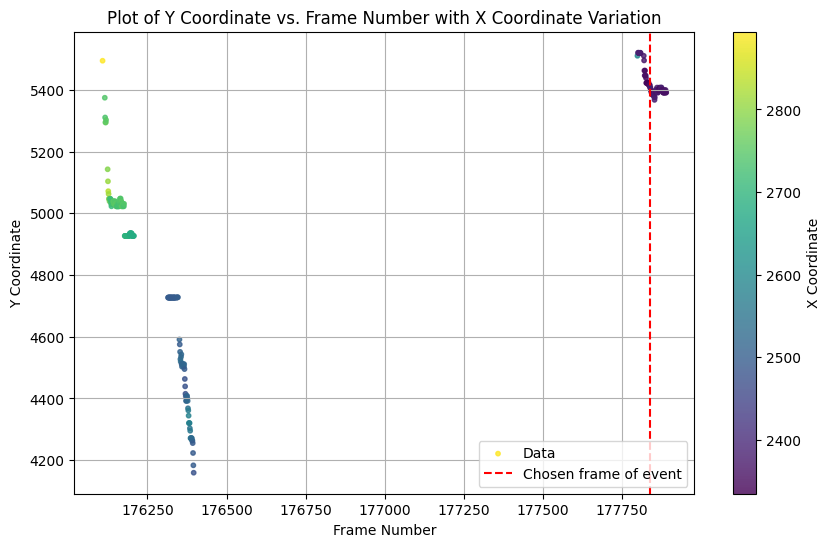

In [48]:
#Test 1/3
plotPoint = pd.DataFrame()
plotPoint = plotEvent(20, plotPoint, 177840.0, 1002, 1800, 50)
plotPoint # finer look into where a leave event is truly located, adjust line accordingly
# make up data to test on

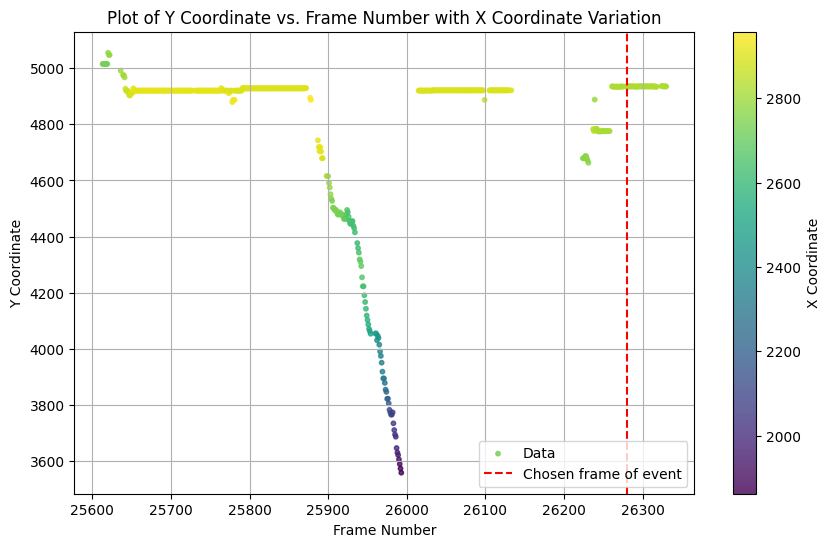

In [49]:
#Test 2/3
plotPoint = pd.DataFrame()
plotPoint = plotEvent(20, plotPoint, 26280.0, 1007, 1800, 50)
plotPoint # add minute markers for clarity and scale

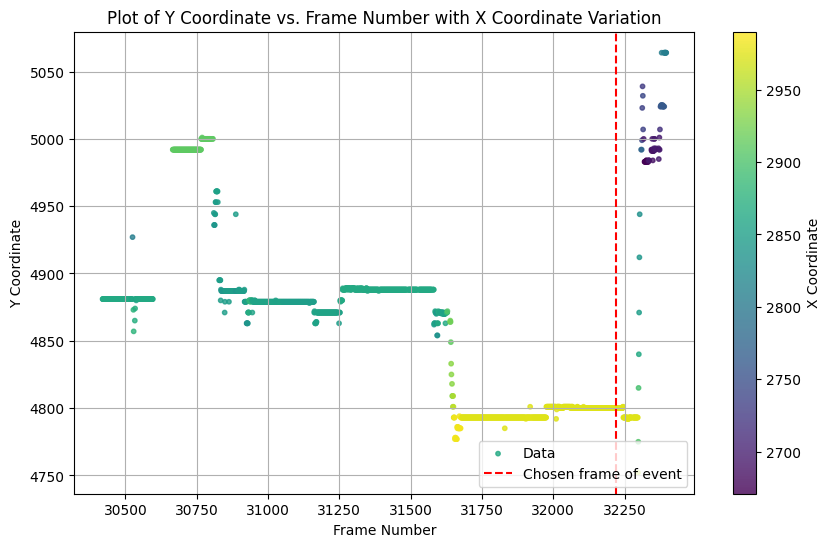

Empty DataFrame
Columns: []
Index: []


In [50]:
#Test 3/3
#Plot surrounding rows. change last two numbers to zoom in or out
plotPoint1 = pd.DataFrame()
plotPoint1 = plotEvent(20, plotPoint1, 32220.0, 1007, 1800, 3000)

#See surrounding rows in df form. change last two numbers to zoom in or out
plottingEvent = pd.DataFrame()
print(plottingEvent)
plotPoint
# put line for bee disappearance/death on graph (conditional plot line)
#double check with exit frame location and distance
# look for standards in the other people's functions for establishing standards of a leaving event

In [51]:
#See your options!
leave = pd.DataFrame()
leave = getLeaveEvents(20,leave)
leave
# update leave events to account for frame by frame and identify true leaving frame

FileNotFoundError: File /home/stefan/jupyter-lab-projects/CLL/bee-data/df_day1min_alldays/df_day1min_20.hdf does not exist

- track each bee, left here, returned here
- then see x y trajectories and see movement to make sure it matches and there arent bugs/logistical errors in the code
- plots

- look closer into events to see more precise times of exit and entering 
- look through more of padma's code and see if it can be incorporated to start on factors of leaving
- plots of bee activity 10 mins before leave event

In [24]:
hiveEvents[hiveEvents['status']!='no change']

NameError: name 'hiveEvents' is not defined

In [62]:
fullHiveEvents = pd.DataFrame()
for x in range(20,26):
    fullHiveEvents = getData(x, fullHiveEvents)
fullHiveEvents

1435
1408
1371
1339
1287
1245


,index,uid,diff,min,framenum,status
0,0,848,0.0,0,0.0,no change
1,1,848,0.0,1,180.0,no change
2,2,848,0.0,2,360.0,no change
3,3,848,0.0,3,540.0,no change
4,4,848,0.0,4,720.0,no change
...,...,...,...,...,...,...
1791550,1791550,3103,0.0,1434,258120.0,no change
1791551,1791551,3103,0.0,1435,258300.0,no change
1791552,1791552,3103,0.0,1436,258480.0,no change
1791553,1791553,3103,0.0,1437,258660.0,no change


<Axes: xlabel='time', ylabel='exit_dist'>

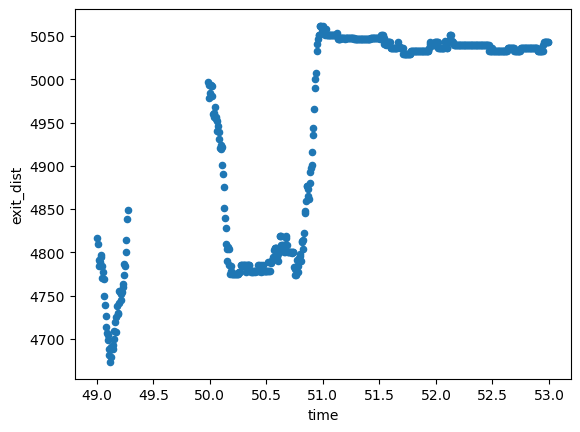

In [20]:
temp.plot('time', 'exit_dist', kind = "scatter")